In [1]:
import sys
sys.path.append("/Users/joosep/Documents/keras")
import keras
import root_numpy as rnpy
import numpy as np
import pandas
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
ptbins = np.linspace(20,620,11)
etabins = np.linspace(0.5,11)
def load_dataset(fn, treename, i):
    arr = rnpy.root2rec(
        fn,
        selection="Jet_pt>20",
        #branches=["Jet_pt", "Jet_eta", "Jet_flavour", "Jet_CSV", "Jet_CSVIVF", "Jet_CombMVA", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP"],
        treename=treename,
        start=0,
        stop=50000
    )
    df = pandas.DataFrame(arr)
    df["id"] = i
    df[np.isnan(df)] = 0.0
    df[np.isinf(df)] = 0.0
    df["abs_eta"] = df["Jet_eta"].abs()
    df["training"] = 0
    
    perminds = np.random.permutation(df.index)
    df.loc[perminds[:len(perminds)/2], "training"] = 1
    df["ptbin"] = map(lambda x: ptbins.searchsorted(x), df["Jet_pt"])
    df["etabin"] = map(lambda x: ptbins.searchsorted(x), df["abs_eta"])
    df["w"] = 1.0
    return df

In [4]:
d1 = load_dataset("../data/jun8/ttjets.root", "tree_b", 2)
d2 = load_dataset("../data/jun8/ttjets.root", "tree_c", 1)
d3 = load_dataset("../data/jun8/ttjets.root", "tree_l", 0)

In [5]:
d = pandas.concat((d1, d2, d3))

In [6]:
def normalize_col(d, col):
    m = d[col].mean()
    d[col] = d[col] - m
    s = d[col].std()
    d[col] = d[col] / s

In [7]:
trainvars3 = [
    "Jet_CSV", "Jet_CSVIVF",
    "Jet_SoftMu", "Jet_SoftEl", "Jet_JP",
]


for tv in trainvars3:
    m =  d[tv].mean()
    s = d[tv].std()
    print tv, d[tv].min(), d[tv].max(), d[tv].mean(), d[tv].std()

    if "Jet" in tv:
        d.loc[d[tv]<= -9, tv] = 0
    if "TagVar" in tv:
        d.loc[d[tv]<= -98, tv] = 0

    d.loc[d[tv]<(m-2*s), tv] = m-2*s
    d.loc[d[tv]>(m+2*s), tv] = m+2*s
    normalize_col(d, "Jet_CSV")
    print tv, d[tv].min(), d[tv].max(), d[tv].mean(), d[tv].std()

Jet_CSV -10.0 136.211 0.0181543292416 2.25194343379
Jet_CSV -1.35943659615 11.6843069699 2.88006655561e-17 1.0
Jet_CSVIVF -10.0 89.9273 0.0607947485247 2.23869528459
Jet_CSVIVF 0.0 4.53819 0.514572887715 0.351684072496
Jet_SoftMu -10.0 0.821025 -8.893729771 3.23514659366
Jet_SoftMu -2.42344 -2.42344 -2.42343664169 0.00140798934877
Jet_SoftEl -10.0 0.842238 -8.01953805703 4.01727841252
Jet_SoftEl 0.0 0.0150188 0.00267610094427 0.00566004811901
Jet_JP -0.0 3.25721 0.369343395736 0.41624654767
Jet_JP -0.0 1.20184 0.351118709945 0.363107483093


In [8]:
d_training = d[d["training"]==1]
d_testing = d[d["training"]==0]

In [9]:
# X_train = np.array(d_training[["Jet_CSV", "Jet_CSVIVF", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP"]])
# y_train = np.array(d_training["id"])

In [10]:
X_train = d_training[["Jet_CSV", "Jet_CSVIVF", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP"]].as_matrix()
y_train = d_training["id"].as_matrix()
y_train2 = (d_training["id"]==2).as_matrix()

In [11]:
X_test = d_testing[["Jet_CSV", "Jet_CSVIVF", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP"]].as_matrix()
y_test = d_testing["id"].as_matrix()
y_test2 = (d_testing["id"]==2).as_matrix()

In [12]:
128+128 + 3*128

640

In [32]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils, generic_utils
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization

dims = X_train.shape[1]
nclasses = 2

model = Sequential()
model.add(Dense(dims, 128, init='glorot_uniform'))

for ilayer in range(4):  
    model.add(PReLU((128,)))
    model.add(Dense(128, 128, init='glorot_uniform'))
    model.add(Dropout(0.5))

model.add(Dense(128, nclasses, init='glorot_uniform'))
model.add(Activation('softmax'))


sgd = SGD(lr=0.6, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
ret = model.fit(X_train, np_utils.to_categorical(y_train2), nb_epoch=50, batch_size=4096, verbose=2, validation_data=(X_test, np_utils.to_categorical(y_test2)),show_accuracy=True)

Train on 75000 samples, validate on 75000 samples
Epoch 0
Epoch 0
Epoch 0
Epoch 0
4s - loss: 0.2254 - acc.: 0.6610 - val. loss: 0.2222 - val. acc.: 0.6667
4s - loss: 0.2254 - acc.: 0.6610 - val. loss: 0.2222 - val. acc.: 0.6667
4s - loss: 0.2254 - acc.: 0.6610 - val. loss: 0.2222 - val. acc.: 0.6667
4s - loss: 0.2254 - acc.: 0.6610 - val. loss: 0.2222 - val. acc.: 0.6667
Epoch 1
Epoch 1
Epoch 1
Epoch 1
5s - loss: 0.2221 - acc.: 0.6667 - val. loss: 0.2219 - val. acc.: 0.6667
5s - loss: 0.2221 - acc.: 0.6667 - val. loss: 0.2219 - val. acc.: 0.6667
5s - loss: 0.2221 - acc.: 0.6667 - val. loss: 0.2219 - val. acc.: 0.6667
5s - loss: 0.2221 - acc.: 0.6667 - val. loss: 0.2219 - val. acc.: 0.6667
Epoch 2
Epoch 2
Epoch 2
Epoch 2
4s - loss: 0.2218 - acc.: 0.6667 - val. loss: 0.2216 - val. acc.: 0.6667
4s - loss: 0.2218 - acc.: 0.6667 - val. loss: 0.2216 - val. acc.: 0.6667
4s - loss: 0.2218 - acc.: 0.6667 - val. loss: 0.2216 - val. acc.: 0.6667
4s - loss: 0.2218 - acc.: 0.6667 - val. loss: 0.221

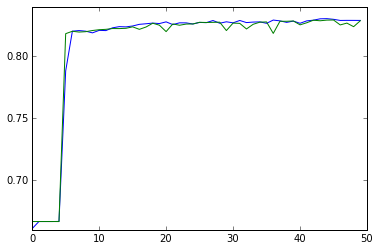

In [33]:
plt.plot(ret.accuracy)
plt.plot(ret.validation_accuracy)

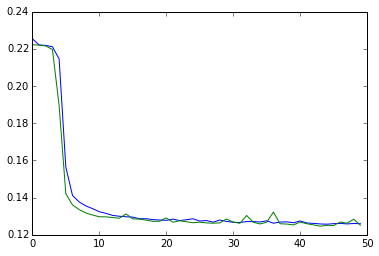

In [34]:
plt.plot(ret.loss)
plt.plot(ret.validation_loss)

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
cls = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.05,
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=100,
    subsample=1.0,
    verbose=True
)

In [26]:
cls.fit(X_train, y_train2)

      Iter       Train Loss   Remaining Time 
         1           1.2305            9.06s
         2           1.1929            7.80s
         3           1.1593            7.63s
         4           1.1293            7.34s
         5           1.1021            7.13s
         6           1.0774            6.95s
         7           1.0549            6.78s
         8           1.0342            6.75s
         9           1.0156            6.63s
        10           0.9984            6.56s
        20           0.8849            5.52s
        30           0.8313            4.71s
        40           0.8045            3.95s
        50           0.7907            3.26s
        60           0.7831            2.59s
        70           0.7785            1.92s
        80           0.7756            1.27s
        90           0.7734            0.64s
       100           0.7718            0.00s


GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=True,
              warm_start=False)

In [35]:
d["p"] = model.predict_proba(d[["Jet_CSV", "Jet_CSVIVF", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP"]])[:, 1]
d["p2"] = cls.predict_proba(d[["Jet_CSV", "Jet_CSVIVF", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP"]])[:, 1]

d_training = d[d["training"]==1]
d_testing = d[d["training"]==0]

150000/150000 [==============================] - 2s     


In [36]:
def cumerr(arr, nb=100000):
    h = np.histogram(
        arr,
        bins=np.linspace(-5,5,nb)
    )
    h = h[0]
    hc = np.cumsum(h)
    he = np.sqrt(np.cumsum(h))
    hc = hc / float(np.sum(h))
    he = he / float(np.sum(h))
    return hc, he

In [37]:
def roc(d, sig, bkg, col, **kwargs):
    ds = d[d.eval(sig)]
    db = d[d.eval(bkg)]
    c1, e1 = cumerr(ds[col], nb=10000)
    c2, e2 = cumerr(db[col], nb=10000)
    plt.plot(1.0 - c1, 1.0 - c2, **kwargs)

(0.5, 1.0)

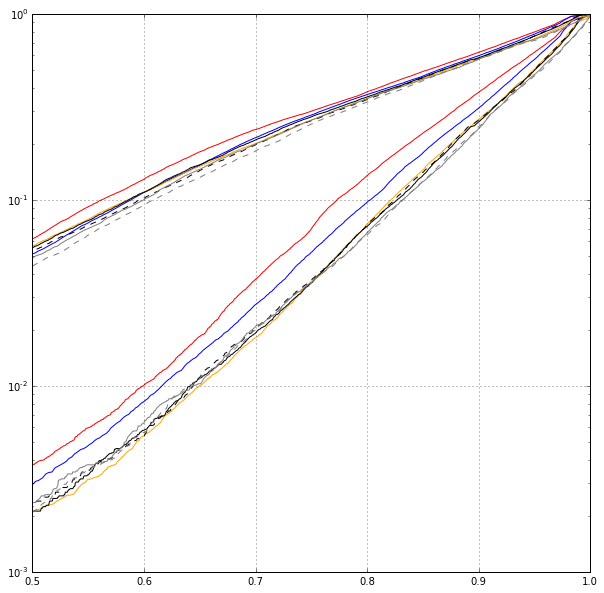

In [38]:
plt.figure(figsize=(10,10))
plt.grid()
roc(d, "id==2", "id==0", "Jet_CSV", color="red")
roc(d, "id==2", "id==0", "Jet_CSVIVF", color="blue")
roc(d, "id==2", "id==0", "Jet_CombMVA", color="orange")
roc(d_testing, "id==2", "id==0", "p", color="black")
roc(d_training, "id==2", "id==0", "p", color="black", ls="--")

roc(d_testing, "id==2", "id==0", "p2", color="gray")
roc(d_training, "id==2", "id==0", "p2", color="gray", ls="--")


roc(d, "id==2", "id==1", "Jet_CSV", color="red", ls="-")
roc(d, "id==2", "id==1", "Jet_CSVIVF", color="blue", ls="-")
roc(d, "id==2", "id==1", "Jet_CombMVA", color="orange", ls="-")
roc(d_testing, "id==2", "id==1", "p", color="black", ls="-")
roc(d_training, "id==2", "id==1", "p", color="black", ls="--")

roc(d_testing, "id==2", "id==1", "p2", color="gray", ls="-")
roc(d_training, "id==2", "id==1", "p2", color="gray", ls="--")


plt.yscale("log")
plt.ylim(0.001, 1.0)
plt.xlim(0.5, 1.0)